# Edit Notes

1/1/2021:    Added code to explicitly install moviepy since pims silently needs it here.

10/18/2021:  Improved visualization functions and added re-computing trajectories after data cuts.

10/13/2021:  This is based off of 0.5.0 version of the Trackpy tutorial.  Features for better visualization of data have been added.


In [4]:
pip install moviepy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pims

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install trackpy

Note: you may need to restart the kernel to use updated packages.


# Walkthrough

This notebook follows an example trackpy project from start to finish. We take video of micron-sized particles diffusing in water, track them, and analyze the trajectories to obtain the viscosity of water.

At the bottom of the notebook, we very briefly survey the more advanced features of trackpy. Browse the [rest of the documentation](https://soft-matter.github.io/trackpy/stable) to learn more.

## Scientific IPython Setup

We need Python's plotting library, matplotlib. Your environment might load matplotlib automatically, but for this tutorial I'll load it explicitly using this convention. If you are unfamiliar with matplotlib, do the same as I do here, and everything that follows will work without modification.

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(8, 4))
mpl.rc('image', cmap='gray')

We also might want to use scientific Python libraries. Finally, we'll import ``trackpy`` itself and its sister project, `pims`.

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

We use the alias ``tp`` for brevity.

## Step 1: Read the Data

### Opening images or video

To get our data into Python, we use our sister project, [PIMS](https://github.com/soft-matter/pims) (Python Image Sequence). PIMS makes it easy and convenient to load and process video data from many formats with one consistent interface.

Using PIMS, trackpy can read:
* a directory or zipfile of sequential images
* a multi-frame TIFF file
* a video (AVI, MOV, etc.)
* specialty formats used in microscopy and scientific video capture:
    * `Cine`, NorPix `seq`
    * `LSM`
    * Files supported by [Bioformats](https://www.openmicroscopy.org/site/support/bio-formats5.1/supported-formats.html)
    * `ND2` using [PIMS_ND2](https://github.com/soft-matter/pims_nd2)

(Some of the formats require some extra dependencies. For a complete list, see the [README page](https://github.com/soft-matter/pims) for PIMS, or the installation instructions in the documentation.)

For many formats, using `pims.open` just works. 

We'll set up a few *pipelines* that will let us manipulate our videos by converting them to grayscale, cropping them, or removing background features. 

To start, we should denote the location of the file we're opening.

In [3]:
filename = 'our_alpha_data.avi'

The following code will load your video, and generate a static background by averaging all frames.  It may give some warnings, but as long as there isn't an error you're fine.

In [4]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

@pims.pipeline
def pcrop(frame,xmin = 500,xmax = 800,ymin=200,ymax=500):
    return frame[ymin:ymax,xmin:xmax] #cropping down the image at first!

@pims.pipeline
def remove_background(frame,back):
    return frame-back

rawframes = gray(pims.open(filename))  # This opens our initial file

reduction_factor = len(rawframes)
bkg = rawframes[0]/reduction_factor
for f in rawframes[1:]:  # This creates a background by literally summing up the pixel brightness values over the whole video, divided by the number of frames.
    bkg += f/reduction_factor

frames = remove_background(rawframes,bkg)  # And now we've removed the background from our data to get something nicer to work with
#subframes = pcrop(remove_background(gray(pims.open(filename)),bkg))
subframe = pcrop(frames) # This lets us pick out a smaller region for testing purposes

/opt/anaconda3/lib/python3.8/site-packages/pims/api.py:207: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
/opt/anaconda3/lib/python3.8/site-packages/pims/api.py:207: UserWarning: <class 'pims.pyav_reader.PyAVReaderIndexed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7ff3774ab5e0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/pims/pyav_reader.py", line 368, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'


You can get some info about your video just by accessing the `frames` object

In [5]:
frames

(Pipeline,) processed through proc_func. Original repr:
    (ImageIOReader,) processed through proc_func. Original repr:
        <FramesSequenceND>
        Axes: 3
        Axis 'x' size: 1024
        Axis 'y' size: 768
        Axis 't' size: 300
        Pixel Datatype: uint8

We can access any frame like `frames[frame_number]`. The image is represented as a numpy array of intensities. These should be in the range `[0, 255]`.

In [6]:
print(frames[0])  # the first frame

[[-1.00333333  1.33666667 -0.91333333 ... -1.13        1.52666667
  -0.10666667]
 [ 1.91333333 -0.14666667  1.00333333 ... -0.96        3.16
   2.88333333]
 [-0.68333333 -0.40333333 -2.3        ...  2.72        2.92
   2.18666667]
 ...
 [ 0.10333333 -0.46666667  0.78666667 ...  1.04666667  3.54
   5.87333333]
 [ 0.47333333 -3.81       -4.37666667 ...  2.16        4.45666667
   5.25666667]
 [-1.15       -3.08333333 -1.57       ...  4.79        3.01666667
   6.38333333]]


In an IPython notebook, the frame is represented directly by displaying the image.

Frame([[-1.00333333,  1.33666667, -0.91333333, ..., -1.13      ,
         1.52666667, -0.10666667],
       [ 1.91333333, -0.14666667,  1.00333333, ..., -0.96      ,
         3.16      ,  2.88333333],
       [-0.68333333, -0.40333333, -2.3       , ...,  2.72      ,
         2.92      ,  2.18666667],
       ...,
       [ 0.10333333, -0.46666667,  0.78666667, ...,  1.04666667,
         3.54      ,  5.87333333],
       [ 0.47333333, -3.81      , -4.37666667, ...,  2.16      ,
         4.45666667,  5.25666667],
       [-1.15      , -3.08333333, -1.57      , ...,  4.79      ,
         3.01666667,  6.38333333]])
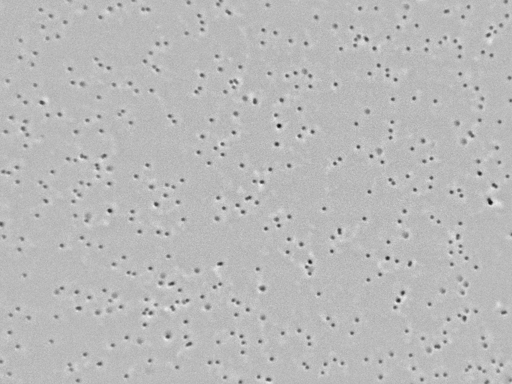

In [7]:
frames[0]

Alternatively, to make a proper plot with axes and control over scaling, use matplotlib's `imshow()` method.

This is also a good opportunity to show what difference subtracting off background features can make.

<IPython.core.display.Javascript object>


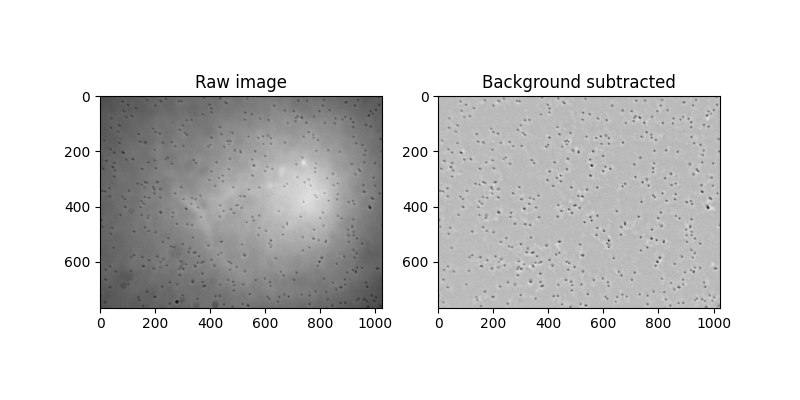

Text(0.5, 1.0, 'Background subtracted')

In [8]:
fig,(ax,ay) = plt.subplots(1,2)
ax.imshow(rawframes[0]);
ax.set_title("Raw image")
ay.imshow(frames[0]);
ay.set_title("Background subtracted")

Frames behave like numpy arrays, but with a few extra properties.

In [9]:
frames[123].frame_no

123

In [10]:
frames[123].metadata  # Scientific formats can pass experiment meta data here.

{'new': False, 'axes': ['y', 'x'], 'coords': {'t': 123}}

## Step 2: Locate Features

Start with just the first frame. Estimate the size of the features (in pixels). The size *must* be an odd integer, and it is better to err on the large side, as we'll see below. We estimate 11 pixels.

In [11]:
f = tp.locate(frames[0], 11, invert=True)

The algorithm looks for *bright* features; since the features in this set of images are dark, we set ``invert=True``.

``locate`` returns a spreadsheet-like object called a DataFrame. It lists 

* each feature's position,
* various characterizations of its appearance, which we will use to filter out spurious features,
* the "signal" strength and an estimate of uncertainty, both derived from [this paper](https://doi.org/10.1529/biophysj.104.042457)

More information about DataFrames may be found in the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html#pandas.DataFrame). DataFrames can easily be exported to formats like CSV, Excel, SQL, HDF5, etc.

In [12]:
f.head()  # shows the first few rows of data

y           x        mass      size       ecc     signal  \
0  4.633166   67.597990   18.911733  3.005857  0.215539   1.330474   
1  4.902518  376.939110  324.635581  2.564108  0.067729  10.833857   
2  3.845238  588.424603   23.948526  2.875733  0.206101   1.900677   
3  4.379747  615.294304   30.030692  3.169774  0.284140   1.520541   
4  3.883721  866.751938   12.259365  2.702282  0.098085   1.045372   

     raw_mass        ep  frame  
0   92.656667  0.221275      0  
1  918.380000  0.071200      0  
2   19.630000  0.271974      0  
3  132.690000  0.200759      0  
4   45.600000  0.251483      0

<IPython.core.display.Javascript object>


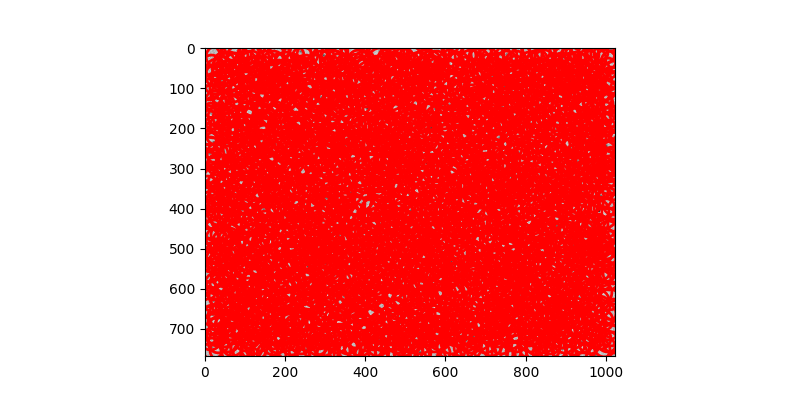

In [13]:
fig,ax = plt.subplots()
tp.annotate(f, frames[0]);

### Refine parameters to elminate spurious features
Many of these circles are clearly wrong; they are fleeting peaks in brightness that aren't actually particles. Rejecting them often improves results and speeds up feature-finding. There are many ways to distinguish real particles from spurious ones. The most important way is to look at total brightness ("mass").

The `mass` is literally the sum of pixel values in a circle of the radius we set previously.  More mass = larger/darker spot.

<IPython.core.display.Javascript object>


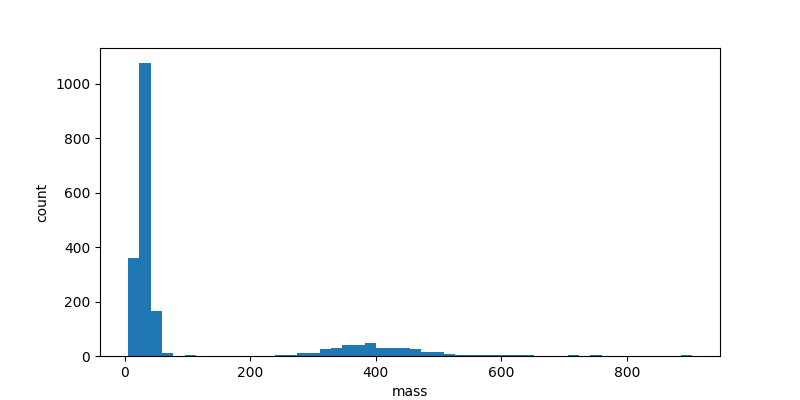

In [14]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=50)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

We can then specify the `minmass` parameter. If your image is especially noisy, you may also find the `threshold` parameter  useful.

In [15]:
f = tp.locate(frames[0], 11, invert=True, minmass=200)

<IPython.core.display.Javascript object>


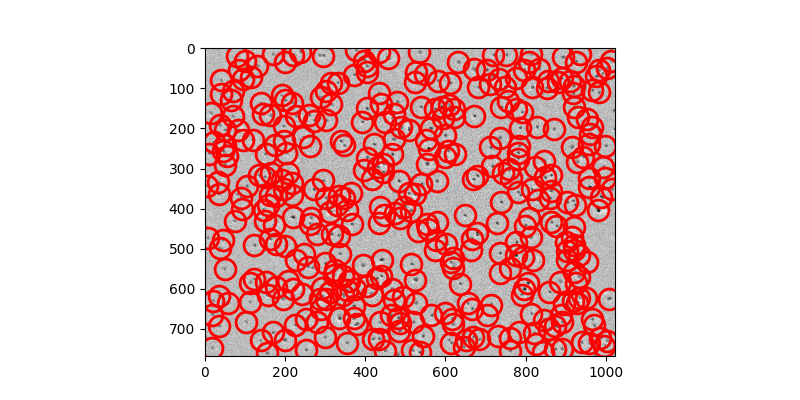

In [16]:
fig,ax = plt.subplots()
tp.annotate(f, frames[0]);

There are more options for controling and optimizing feature-finding. You can review them in the [documentation](https://soft-matter.github.io/trackpy/stable/), where the most comprehensive description is in the API reference. Or, pull them up as you work by typing ``tp.locate?`` into IPython.

### Check for subpixel accuracy
As Eric Weeks points out in his related tutorial, a quick way to check for subpixel accuracy is to check that the decimal part of the x and/or y positions are evenly distributed. Trackpy provides a convenience plotting function for this called `subpx_bias`:

<IPython.core.display.Javascript object>


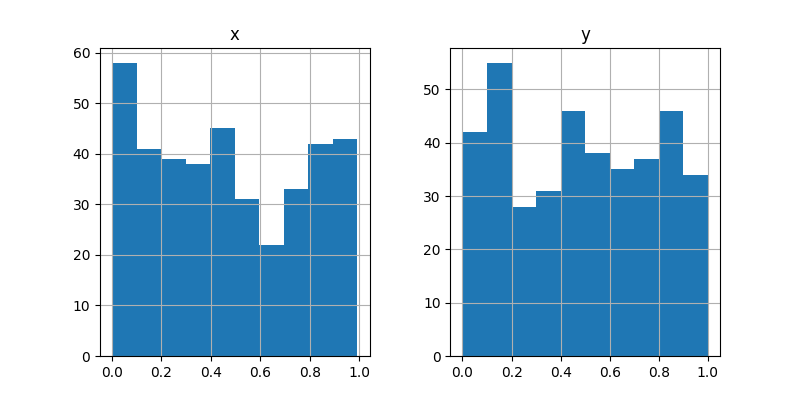

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

In [17]:
tp.subpx_bias(f)

If we use a mask size that is too small, the histogram often shows a dip in the middle.

<IPython.core.display.Javascript object>


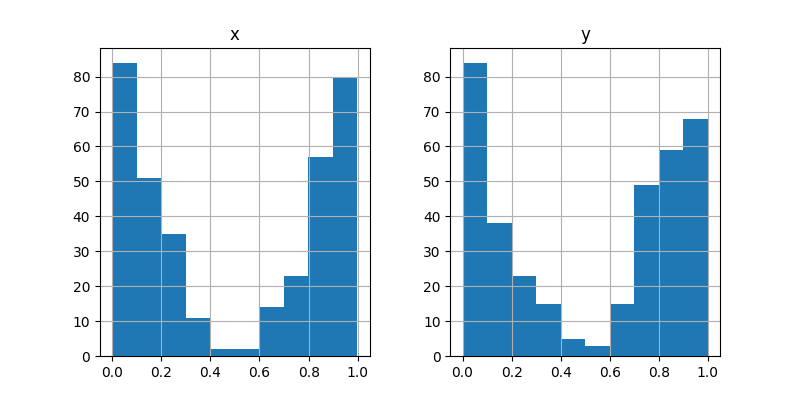

In [18]:
tp.subpx_bias(tp.locate(frames[0], 5, invert=True, minmass=20));

### Exploring your data

We've edited this part to create an interactive method of seeing how varying different parameters affects particle identification.

The variables are as follows:

 - `fnum` is the frame number.  Make sure your parameters work past the first video frame!
 - `dia` is the particle diameter
 - `mratio` controls the mass, but in a way that scales with the selected diameter
   - Without this, you'd have to tweak the mass almost every time you adjusted the particle size
 - `separate` is the how far apart two blobs *must* be to be detected as separate particles.   
 
The **green dot** shows roughly how big of particles the software is searching for.

<IPython.core.display.Javascript object>


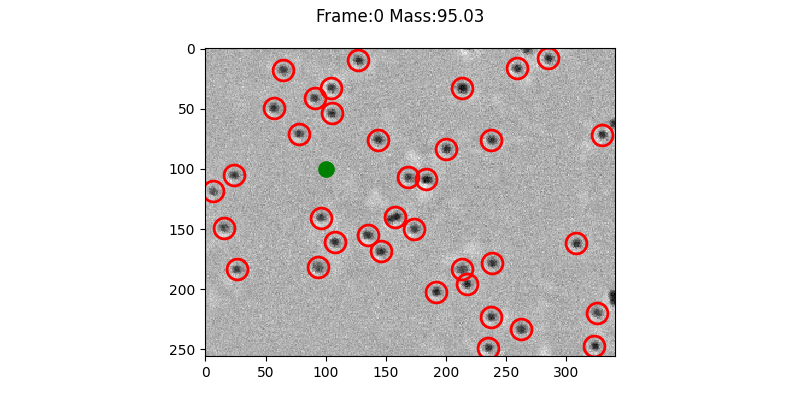

interactive(children=(IntSlider(value=0, description='fnum', max=299), IntSlider(value=11, description='dia', …

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

if not ('d' in locals()): # This only defines values for these variables if they don't exist yet
    d = 11                # This means that you won't have your work destroyed by re-loading the cell
    mr = 1
    sepa = 12

ymin = int(0.333 * frames[0].shape[0])
ymax = int(0.666 * frames[0].shape[0])
xmin = int(0.333 * frames[0].shape[1])
xmax = int(0.666 * frames[0].shape[1])
subframe = pcrop(frames,xmin,xmax,ymin,ymax)
# all this focuses our view on only the middle of the image, which saves time & processing power.

fig,ax = plt.subplots(figsize = (8,4))
def newshowframe(fnum = 0,dia=d,mratio =mr,separate = sepa):
    global d
    global mr
    global sepa
    d = dia
    mr = mratio
    sepa = separate
    fig.clear()
    mmass = mratio * np.pi * dia**2/4
    newf =  tp.locate(subframe[fnum], diameter = dia, invert=True, minmass=mmass,separation = separate)
        # the above is the workhorse here, calling the locate function with our specified parameters 
    tp.annotate(newf, subframe[fnum]);
    plt.plot(100,100,'go',ms=dia)
    fig.suptitle("Frame:{} Mass:{:.2f}".format(fnum,mmass))
interact(newshowframe, fnum=(0,len(frames)-1),dia=(3,31,2),mratio=(0.01,20),separate = (1,31));
# This adds sliders that let you interact with your data

In [20]:
print("Diameter:  {}".format(d))
mm =  mr * np.pi * d**2/4
print("Mass:  {:0.2f}".format(mm))
print("Separation:  {}".format(sepa))

Diameter:  11
Mass:  95.03
Separation:  12


After you're satisfied that you've got mostly particles selected, the next cell is used to process all of the frames at once.

In [21]:
f = tp.batch(frames, diameter=d, minmass=mm, invert=True,processes=1,separation=sepa);

Frame 299: 388 features


As each frame is analyzed, `tp.batch` reports the frame number and how many features were found. If this number runs unexpectedly low or high, you may wish to interrupt it and try different parameters. 

## Step 3: Link features into particle trajectories
We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification.

First, we must must specify a maximum displacement, the farthest a particle can travel between frames. We should choose the smallest reasonable value because a large value slows computation time considerably. In this case, 5 pixels is reasonable.

Second, we allow for the possibility that a particle might be missed for a few frames and then seen again. (Perhaps its `mass` slipped below our cutoff due to noise in the video.) Memory keeps track of disappeared particles and maintains their ID for up to some number of frames after their last appearance. Here we use 3 frames.

In [22]:
t = tp.link(f, search_range=5, memory=3)

Frame 299: 388 trajectories present.


The result is the features DataFrame `f` with an additional column, `particle`, identifying each feature with a label. We denote this new DataFrame `t`.

----
Now we'll again visualize our data, showing what constitues a particle that is being consistently tracked.
  - Green indicates that a particle has just been identified this frame
  - Yellow indicates continued tracking of a particle
  - Red indicates that a particle is no longer being tracked.

There are a few common reasons for particles to repeatedly pop in/out of detection:
  - Their `mass` might be fluctuating due to lighting variations
  - Two particles might be too close together
  - The particle might be too close to the edge of the screen

<IPython.core.display.Javascript object>


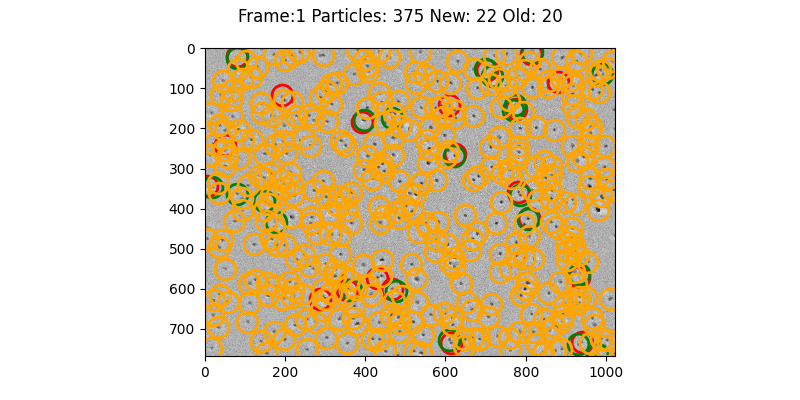

interactive(children=(IntSlider(value=1, description='fnum', max=298, min=1), Output()), _dom_classes=('widget…

<function __main__.link_explorer(fnum=1)>

In [23]:
fig,ax = plt.subplots(figsize = (8,4))
def link_explorer(fnum = 1):  
    p1 = t[t['frame']==fnum-1]['particle']
    p2 = t[t['frame']==fnum]['particle']
    old1 = (set(p1)-set(p2))
    new1 = (set(p2)-set(p1))
    current = set(np.unique(np.append(p1.values,p2.values)))-old1-new1
    ot = t[t['frame']==fnum-1][t[t['frame']==fnum-1].particle.isin(old1)]
    nt = t[t['frame']==fnum][t[t['frame']==fnum].particle.isin(new1)]
    cur = t[t['frame']==fnum][t[t['frame']==fnum].particle.isin(current)]
    fig.clear()
    tp.annotate(ot,frames[fnum])
    tp.annotate(nt,frames[fnum],color='green')  
    tp.annotate(cur,frames[fnum],color='orange')  
    fig.suptitle("Frame:{} Particles: {} New: {} Old: {}".format(fnum,len(cur),len(nt),len(ot)))
interact(link_explorer, fnum=(1,len(frames)-2))

In [24]:
t.head()

y           x        mass      size       ecc     signal  \
0      4.902518  376.939110  324.635581  2.564108  0.067729  10.833857   
269  528.153256  903.169302  408.645491  2.420311  0.057361  16.155752   
268  527.669636  819.321298  597.477722  2.954374  0.232247  16.250786   
267  528.134879  227.183878  360.748438  2.605013  0.151400  12.924602   
266  527.152307  440.532692  622.091485  2.832367  0.283646  19.481936   

        raw_mass        ep  frame  particle  
0     918.380000  0.071200      0         0  
269  1011.940000  0.066119      0         1  
268  1524.043333  0.047547      0         2  
267   885.770000  0.073159      0         3  
266  1644.810000  0.044593      0         4

### Filter spurious trajectories

We have more filtering to do. Ephemeral trajectories — seen only for a few frames — are usually spurious and never useful. The convenience function `filter_stubs` keeps only trajectories that last for a given number of frames.

In [25]:
t1 = tp.filter_stubs(t, threshold=25)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 4114
After: 1505


<IPython.core.display.Javascript object>


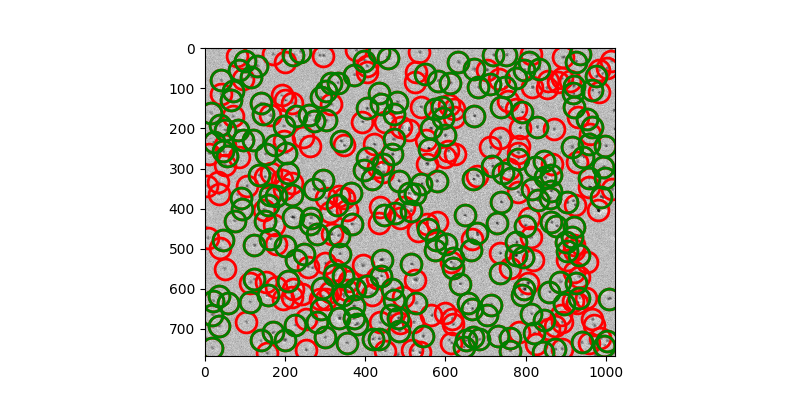

In [26]:
# Red indicates particles that were filtered out
# Green indicates ones that were kept

fig,ax = plt.subplots()
tp.annotate(f[f['frame']==0], frames[0]);
tp.annotate(t1[t1['frame']==0], frames[0],color='green');

We can also filter trajectories by their particles' appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.

<IPython.core.display.Javascript object>


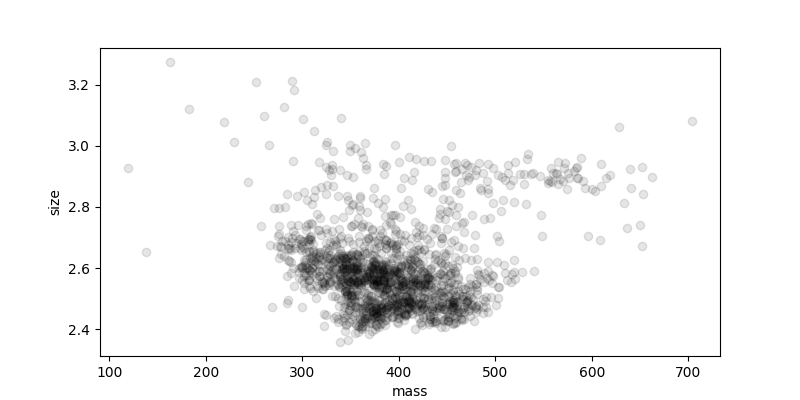

<IPython.core.display.Javascript object>


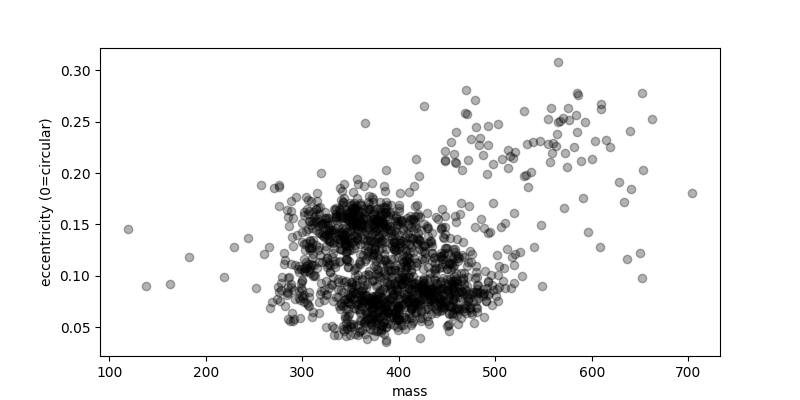

In [27]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass
plt.figure()
tp.mass_ecc(t1.groupby('particle').mean());

The particles with especially low mass, or that are especially large or non-circular (eccentric), are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, filtering out regions of mass-size space and looking at the results using `tp.annotate`. In the end, we need to separate the good particles from the spurious ones, and it doesn't matter how we get it done.

In [28]:
t2 = t1[((t1['mass'] > 250) & (t1['mass'] < 600) & (t1['size'] < 3) & (t1['ecc'] < 0.25))]

Now let's show which particles made the cut and which didn't.
Red indicates that a particle should no longer be considered that frame by trackpy.

<IPython.core.display.Javascript object>


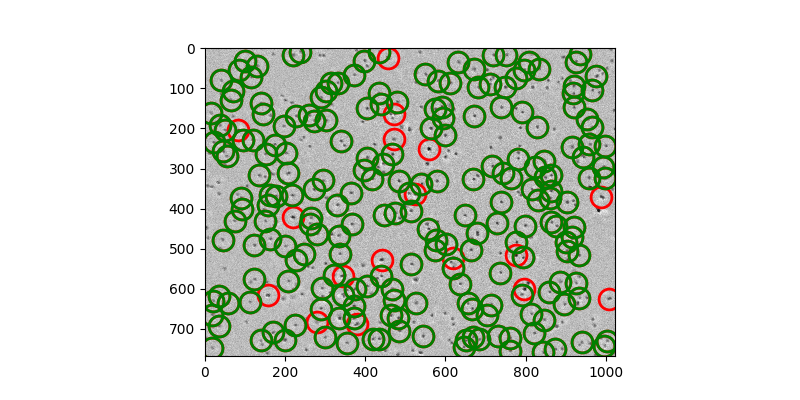

In [29]:
plt.figure()
tp.annotate(t1[t1['frame']==0], frames[0]);
tp.annotate(t2[t2['frame'] == 0], frames[0],color='green');

We can also do this in an interactive way that will let us make sure that something funky isn't happening over time

<IPython.core.display.Javascript object>


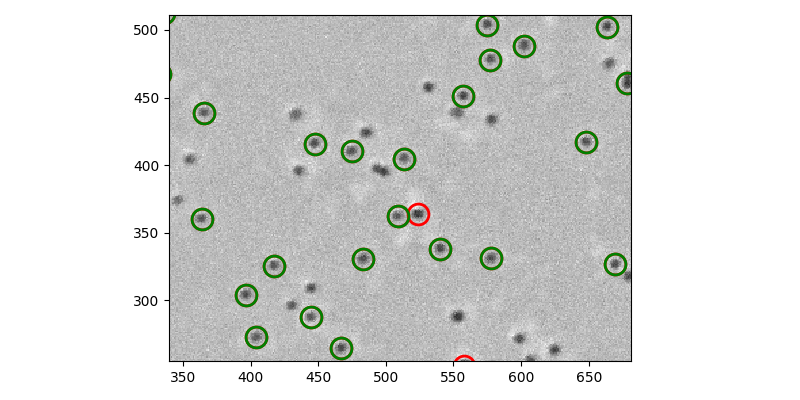

interactive(children=(IntSlider(value=0, description='fnum', max=299), IntSlider(value=250, description='minm'…

In [30]:
if not ('minmass' in locals()): # This only defines values for these variables if they don't exist yet
    minmass = 250                # This means that you won't have your work destroyed by re-loading the cell
    maxmass = 600
    maxsize = 3
    maxecc = .25

ymin = int(0.333 * frames[0].shape[0])
ymax = int(0.666 * frames[0].shape[0])
xmin = int(0.333 * frames[0].shape[1])
xmax = int(0.666 * frames[0].shape[1])
subframe = pcrop(frames,xmin,xmax,ymin,ymax)
# all this focuses our view on only the middle of the image, which saves time & processing power.

fig,ax = plt.subplots(figsize = (8,4))
def newshowframe(fnum = 0,minm=minmass,maxm=maxmass,msize=maxsize,mecc=maxecc):
    global minmass
    global maxmass
    global maxsize 
    global maxecc
    minmass = minm
    maxmass = maxm
    maxsize = msize
    maxecc = mecc
    fig.clear()
    t2 =  t1[((t1['mass'] > minm) & (t1['mass'] < maxm) & (t1['size'] < maxsize) & (t1['ecc'] < maxecc))]
        # the above is the workhorse here, calling the locate function with our specified parameters 
    tp.annotate(t1[t1['frame']==fnum], frames[fnum]);
    tp.annotate(t2[t2['frame']==fnum], frames[fnum],color="green");
    plt.gca().set_xlim(xmin,xmax)
    plt.gca().set_ylim(ymin,ymax)
    plt.tight_layout()
interact(newshowframe, fnum=(0,len(frames)-1),minm=(0,1000),maxm=(0,1000),msize=(0,10,0.01),mecc=(0,1,0.01));
# This adds sliders that let you interact with your data

In [31]:
print("Minimum mass:  {}".format(minmass))
print("Maximum mass:  {}".format(maxmass))
print("Maximum size:  {}".format(maxsize))
print("Maximum eccentricity:  {}".format(maxecc))

Minimum mass:  250
Maximum mass:  600
Maximum size:  3.0
Maximum eccentricity:  0.25


After we've done this, we should re-run our particle finding code now that we're filtering out a good number of data points.  This is done with minimal explanation below.

In [32]:
import copy
t3 = copy.deepcopy(t2)
t3.drop(columns=['particle'])
t_prime = tp.link(t3, search_range=5, memory=3)
t1_prime = tp.filter_stubs(t_prime, threshold=25)
print("Done")

Frame 299: 219 trajectories present.
Done


With this done, we can compare our previously sliced trajectories with the new ones using `plot_traj()`.  Hopefully this will eliminate the most borderline of particles.  Try zooming in on an area to see the difference this makes.

<IPython.core.display.Javascript object>


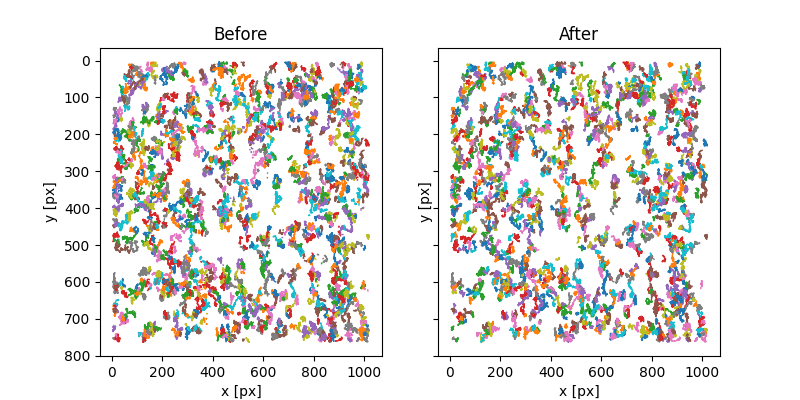

In [33]:
fig,(ax,ay) = plt.subplots(1,2,sharex=True, sharey=True)
plt.sca(ax)
tp.plot_traj(t2)
plt.sca(ay)
tp.plot_traj(t1_prime)
ax.set_title("Before")
ay.set_title("After")
plt.show()

----
Now let's just take a look at one of our particles as it moves, again to check that things behave as expected

<IPython.core.display.Javascript object>


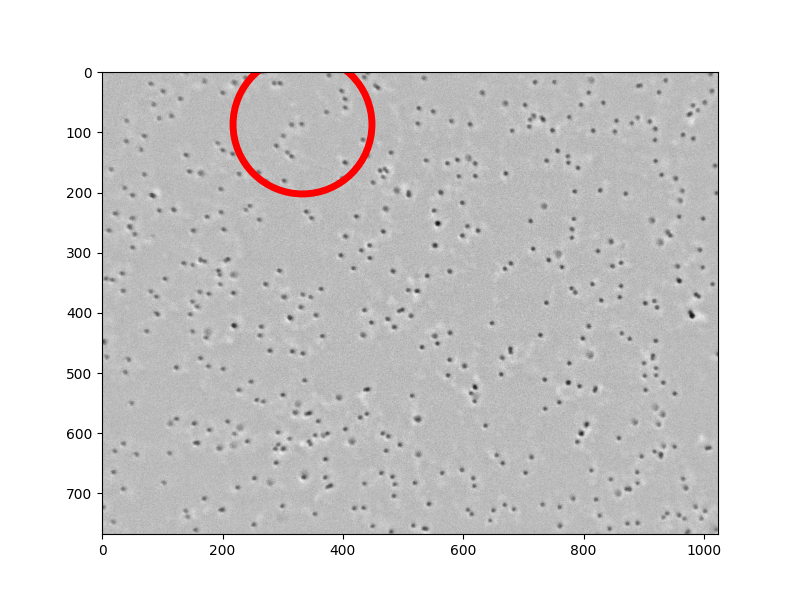

122


In [34]:
particle_select = 0
selected_particle = np.unique(t1_prime['particle'].values)[particle_select]
particle_path = t1_prime[t1_prime['particle'] == np.unique(t1_prime['particle'].values)[particle_select]]

import matplotlib.animation as animation
fig1,ax1 = plt.subplots(figsize = (8,6))
flist = []
xp = []
yp = []

buffer=10
fpframe=min(particle_path['frame'])
lpframe=max(particle_path['frame'])
fframe= max(0,fpframe-buffer)
lframe= min(max(t1_prime['frame']),lpframe+buffer)  # this defines the first/last frames of our video, with a buffer before/after the particle is detected.


for index in range(fframe,lframe): #we'll go between the first and last frames for this loop.
    flist.append(index)   
    try:
        px = t1_prime[(t1_prime['particle'] == selected_particle)&(t1_prime['frame']==index)]['x'].values[0]
    except:
        px = np.nan  #If the particle blips out, we register its position as not a number.
    try:
        py = t1_prime[(t1_prime['particle'] == selected_particle)&(t1_prime['frame']==index)]['y'].values[0]
    except:
        py=np.nan # same as dx
    xp.append(px)
    yp.append(py)

def ini():
    ax1.imshow(frames[flist[0]])
    ax1.plot(xp[0],yp[0],"o",alpha = 1,mec="red",fillstyle='none',markersize=100,mew=5)
    return ax1

def updatefig(i):
    ax1.clear()
    ax1.imshow(frames[flist[i]])
    ax1.plot(xp[i],yp[i],'go',alpha = 1,fillstyle='none',markersize=15,mew=2,zorder=5)
    ax1.plot(xp[fpframe],yp[fpframe],"o",alpha = 1,mec="red",fillstyle='none',markersize=100,mew=5)
    xv = t1_prime[t1_prime['frame']==flist[i]]['x'].values
    yv = t1_prime[t1_prime['frame']==flist[i]]['y'].values
    ax1.scatter(xv,yv,70,alpha=0.3)
    return ax1

print(len(flist))
ani = animation.FuncAnimation(fig1, updatefig,  frames=len(flist), init_func=ini, interval=100, repeat_delay=200)

We can also make a histogram of how far the particle is moving each given frame.

<IPython.core.display.Javascript object>


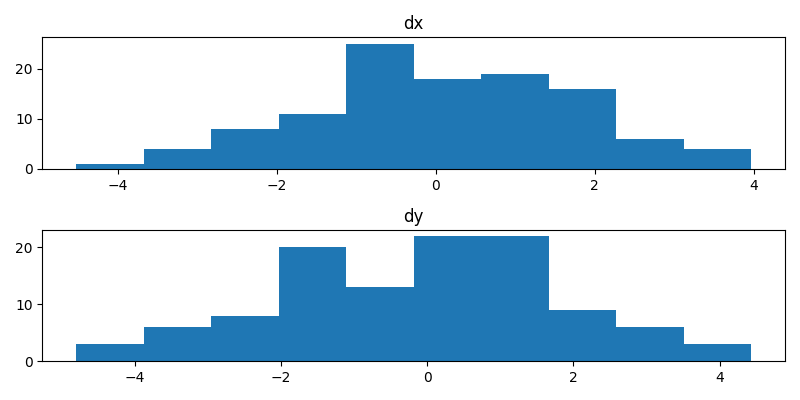

In [35]:
# this kills the animation
try:
    ani._stop()
except:
    pass
fig,(ax,ay) = plt.subplots(2)

xval = np.array(xp)[~np.isnan(np.array(xp))]
yval = np.array(yp)[~np.isnan(np.array(yp))]
xsteps = (np.array(xval[:-1])-np.array(xval[1:]))
ysteps = (np.array(yval[:-1])-np.array(yval[1:]))

# This plots histograms of the particle's steps in the 'x' and 'y' directions.  
# These should be roughly symmetrical, but there might be some drift unaccounted for at this point.


ax.hist(xsteps)
ax.set_title("dx")
ay.hist(ysteps)
ay.set_title("dy")
fig.tight_layout()

### Remove overall drift

This computes the overall drifting motion, which we will subtract away, adopting the reference frame of the particles' average position.

<IPython.core.display.Javascript object>


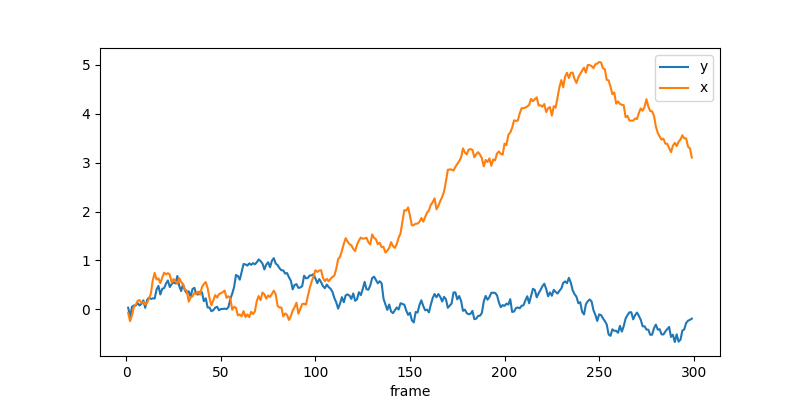

In [36]:
d = tp.compute_drift(t1_prime)
d.plot()
plt.show()

<IPython.core.display.Javascript object>


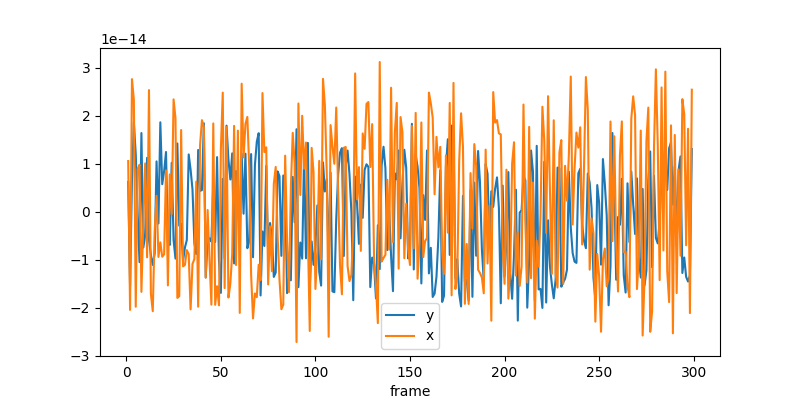

In [37]:
tm = tp.subtract_drift(t1_prime, d)
q = tp.compute_drift(tm)
q.plot()
plt.show()

With the overall drifting motion subtracted out, we plot the trajectories again.  We've set up the following plot to show both before and after trajectories side-by-side.

If you're wondering, `plt.sca(ax)` is a command to `Set the Current Axes to ax`.  This is needed because trackpy is set to just draw on the last subplot that was created otherwise. 

<IPython.core.display.Javascript object>


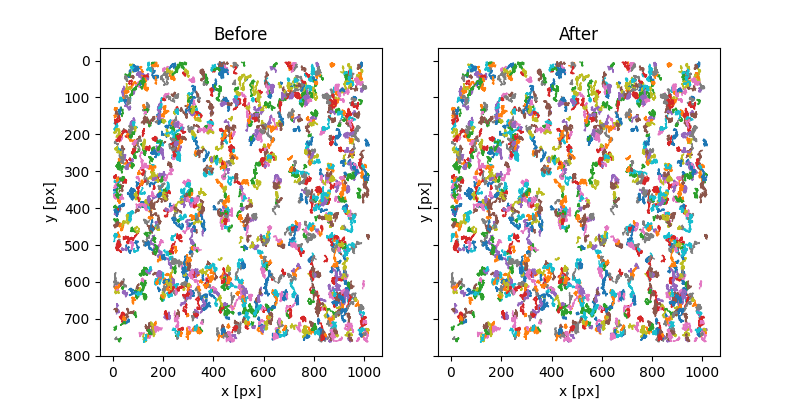

In [38]:
fig,(ax,ay) = plt.subplots(1,2,sharex=True, sharey=True)
plt.sca(ax)
tp.plot_traj(t1_prime)
plt.sca(ay)
tp.plot_traj(tm)
ax.set_title("Before")
ay.set_title("After")
plt.show()

## Step 4: Analyze trajectories

Trackpy includes several functions to help with some common analyses for particle trajectories. (See the "Static Analysis" and "Motion Analysis" sections of the API reference.)

Here, we can show that these data are consistent with colloidal particles undergoing Brownian motion in water.

### Mean Squared Displacement of Individal Probes

This computes the mean squared displacement (MSD) of each particle using the `imsd` function, and plot MSD vs. lag time.

The expectation is that, if you follow any given particle, its displacement from the starting point should grow proportionally to the square root of the time that's passed, $sqrt(t)$

This applies if you're starting from t=0 or from any given step along the particle's trajectory

This function calculates the displacement for each particle at each time step, and aggregates it together on a log-log plot.

In [39]:
im = tp.imsd(tm, mpp = 0.164,fps =10) #mpp is microns per pixel, fps is frames per second.

<IPython.core.display.Javascript object>


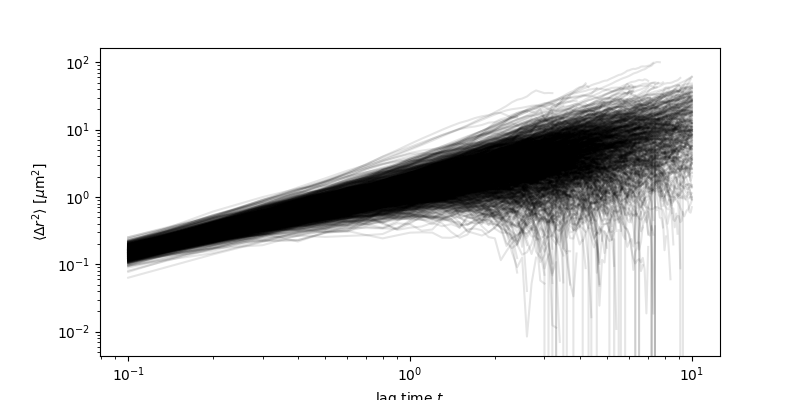

In [40]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

In this instance we only analyzed 300 frames, and the statistics are poor at large lag times. With more frames, we can study larger lag times.

### Ensemble Mean Squared Displacement

Now use the `emsd` function to compute the ensemble mean squared displacement (EMSD) of all particles.
This essentially averages the displacements for each time step of the above plot to capture data about the bulk (ensemble) data.

The function might complain when you run it, but it should still work fine.

In [41]:
em = tp.emsd(tm,  0.164,10)

/opt/anaconda3/lib/python3.8/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/opt/anaconda3/lib/python3.8/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


<ipython-input-42-a7db262f4b3d>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


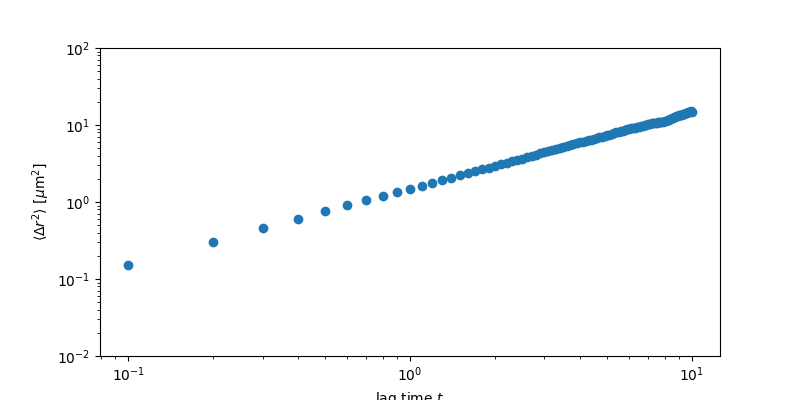

In [42]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 100));

We can easily fit this ensemble mean-squared displacement to a power law, $At^n$, using a convenience function, `fit_powerlaw`, which performs a linear regression in log space.

<IPython.core.display.Javascript object>


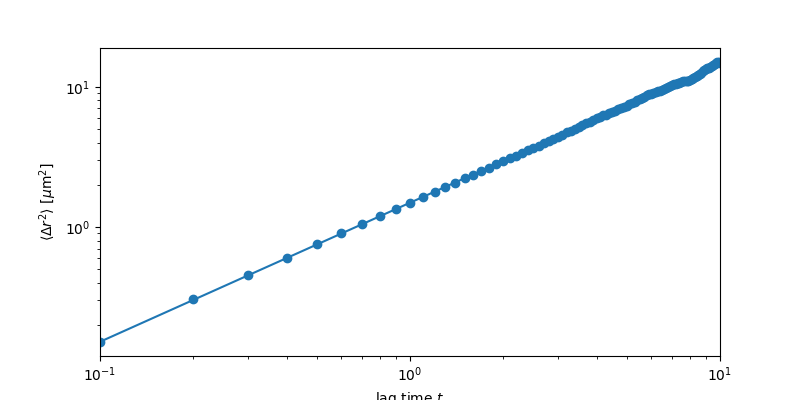

n        A
msd  0.991004  1.48961

In [43]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

In water, a viscous material, the expected power-law exponent $n = 1$. The value of $A = 4D$, where $D$ is the particles' diffusivity. $D$ is related to viscosity $\eta$, particle radius $r$, and temperature $T$ through the Stokes-Einstein equation:

$$
D = \displaystyle\frac{k_B T}{6\pi\eta r}
$$

where $k_B$ is the Boltzmann constant. For particles with a 1 $\mu\text{m}$ diameter in room-temperature water, $A \approx 1.66$ $\mu\textrm{m}^2 / \textrm{s}$. Our value of $n$ is spot-on, but $A$ is above what we'd expect.  Furthermore, this method doesn't give us any estimation of the uncertainty on the parameters.  However, there is another way to extract our parameters.

(If you'd like to know more about this measurement and its uncertainty, [this paper](https://dx.doi.org/10.1119/1.4803529) is a thorough discussion at the advanced undergraduate level.)

# === Our Code ===
----

We'll now use our own code to instead look only at how far each particle moves during each single time step.  

In [44]:
import ipywidgets as widgets

xm = tm['particle'].unique()
are_we_done_yet = widgets.IntProgress(value=0,min=0, max=len(xm),description='Processing:')
display(are_we_done_yet)
output_array = np.zeros((1,3))

for index,item in enumerate(xm[:]): # this starts a loop over all particles
    are_we_done_yet.value=index
    last_frame = tm[tm['particle']==item]['frame'].values[0]
    last_x = tm[tm['particle']==item]['x'].values[0]
    last_y = tm[tm['particle']==item]['y'].values[0]
    for f in tm[tm['particle']==item]['frame'][1:]: # this loops over the frames for one particle
        if(f-last_frame == 1): # only record displacements between adjacent frames
            new_x = tm[(tm['particle']==item)&(tm['frame']==f)]['x'].values[0]
            new_y = tm[(tm['particle']==item)&(tm['frame']==f)]['y'].values[0]
            dx = new_x-last_x
            dy = new_y-last_y
        last_x=new_x
        last_y=new_y
        last_frame = f
        output_array = np.append(output_array,np.array([[dx,dy,int(item)]]),axis=0)
print("Done!")

IntProgress(value=0, description='Processing:', max=1362)

Done!


Our `output_array` now contains a list of `x` and `y` displacements, along with which particle they belong to

In [45]:
output_array[0:5]

array([[ 0.        ,  0.        ,  0.        ],
       [-1.71736696,  0.9719211 ,  1.        ],
       [-1.60931271, -0.86670597,  1.        ],
       [-1.74182862, -2.67819426,  1.        ],
       [ 0.6521708 , -0.90970158,  1.        ]])

We can then do some python array manipulation to select just the 0th column `[:,0]` and make a histogram of the `x` displacements

Note that you may need to change the `range` for your data, there was a bug that caused absurd values to occur in this dataset for some reason.

<IPython.core.display.Javascript object>


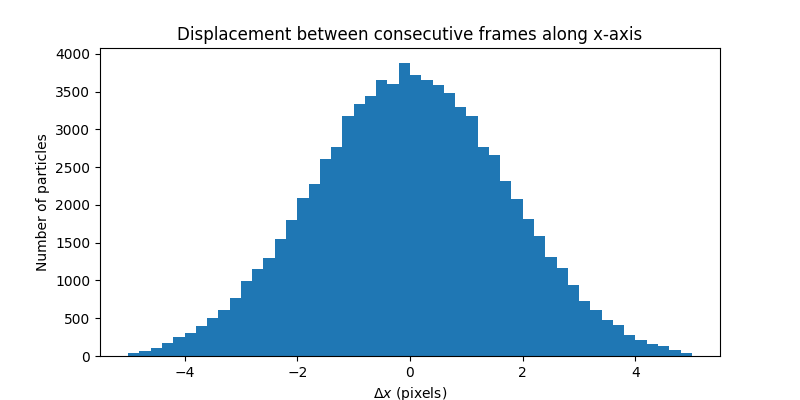

Text(0.5, 1.0, 'Displacement between consecutive frames along x-axis')

In [56]:
fig,ax = plt.subplots()
ax.hist(output_array[:,0],bins=50,range=(-5,5))
plt.xlabel('$\\Delta x$ (pixels)')
plt.ylabel('Number of particles')
plt.title('Displacement between consecutive frames along x-axis')

<IPython.core.display.Javascript object>


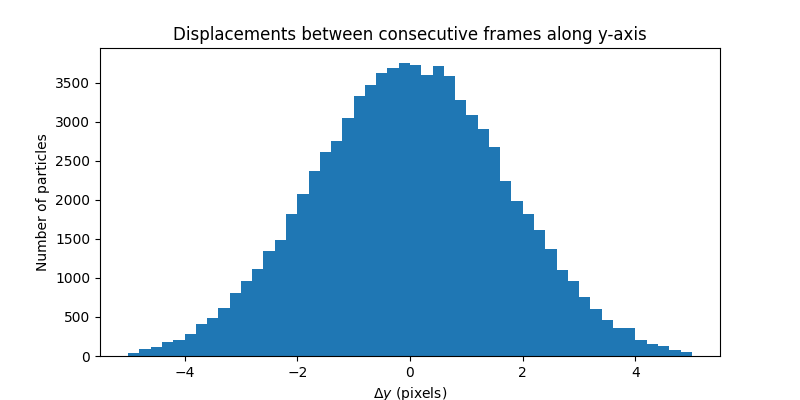

Text(0.5, 1.0, 'Displacements between consecutive frames along y-axis')

In [57]:
fig,ax = plt.subplots()
ax.hist(output_array[:,1],bins=50,range=(-5,5))
plt.xlabel('$\\Delta y$ (pixels)')
plt.ylabel('Number of particles')
plt.title('Displacements between consecutive frames along y-axis')

----

Now let's fire up our fitting routines that we've used before and try to fit a Gaussian to this data.

In [58]:
from scipy import optimize
def data_fit(p0,func,xvar, yvar, err,tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err),verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0,np.zeros_like(p0),-1,-1
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf,np.zeros_like(pf),-1,-1
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf,func,xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

In [59]:
def fitfunc(p,x):  
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))
def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

In [60]:
dxhist = np.histogram(output_array[:,0],bins=50,range=(-5,5))
errdx = np.sqrt(dxhist[0])
errdx[errdx<1] = 1.4 # This sets the correct Poisson uncertainty when N = 0
cbins = (dxhist[1][:-1]+dxhist[1][1:])/2

p0x = [300000., 0, 1]
pfx, pferrx, chisqx, dofx = data_fit(p0x,fitfunc, cbins, dxhist[0], errdx)

# We'll save these for later
sigma_x = pfx[2]
dsigma_x = pferrx[2]


Converged with chi-squared 94.96
Number of degrees of freedom, dof = 47.00
Reduced chi-squared 2.02

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.000e+05                | 1.634e+04                | 5.729e+01               
1           | 0.000e+00                | -1.252e-03               | 6.127e-03               
2           | 1.000e+00                | 1.718e+00                | 4.569e-03               


<IPython.core.display.Javascript object>


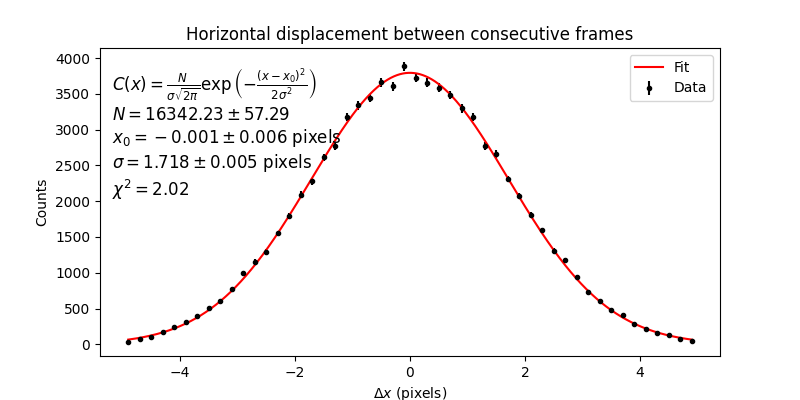

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(cbins, dxhist[0], errdx, fmt='k.', label='Data')

X = np.linspace(min(cbins), max(cbins), 5000)
ax.plot(X, fitfunc(pfx, X), 'r-', label='Fit')

ax.set_title('Horizontal displacement between consecutive frames')
ax.set_xlabel('$\Delta x$ (pixels)')
ax.set_ylabel('Counts')
ax.legend()

textfit = '$C(x) = \\frac{N}{\sigma\sqrt{2\pi}}\\exp\\left(-\\frac{(x-x_0)^2}{2\sigma^2}\\right)$ \n'
textfit += '$N = {:.2f} \pm {:.2f}$ \n'.format(pfx[0], pferrx[0]) 
textfit += '$x_0 = {:.3f} \pm {:.3f}$ pixels\n'.format(pfx[1], pferrx[1]) 
textfit += '$\sigma= {:.3f} \pm {:.3f}$ pixels \n'.format(pfx[2], pferrx[2]) 
textfit += '$\chi^2= {:.2f}$ \n'.format(chisqx/dofx) 

ax.text(0.02, .94, textfit, transform=ax.transAxes, fontsize=12,
             verticalalignment='top')

save_pic = False
#un-comment the above to save a picture to pdf

if (save_pic):
    {
    plt.savefig(output_folder + '/histogram_dx.pdf')
    }
plt.show()

----

In [62]:
#dyhist = np.histogram(output_array[:,1],bins=50)
dyhist = np.histogram(output_array[:,1],bins=50,range=(-5,5))
errdy = np.sqrt(dyhist[0])
errdy[errdy<1] = 1.4 # This sets the correct Poisson uncertainty when N = 0
cbins = (dyhist[1][:-1]+dyhist[1][1:])/2

p0y = [300000., 0, 1]
pfy, pferry, chisqy, dofy = data_fit(p0y,fitfunc, cbins, dxhist[0], errdy)

# We'll save these for later
sigma_y = pfy[2]
dsigma_y = pferry[2]


Converged with chi-squared 92.04
Number of degrees of freedom, dof = 47.00
Reduced chi-squared 1.96

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.000e+05                | 1.635e+04                | 5.731e+01               
1           | 0.000e+00                | -1.831e-03               | 6.134e-03               
2           | 1.000e+00                | 1.720e+00                | 4.600e-03               


<IPython.core.display.Javascript object>


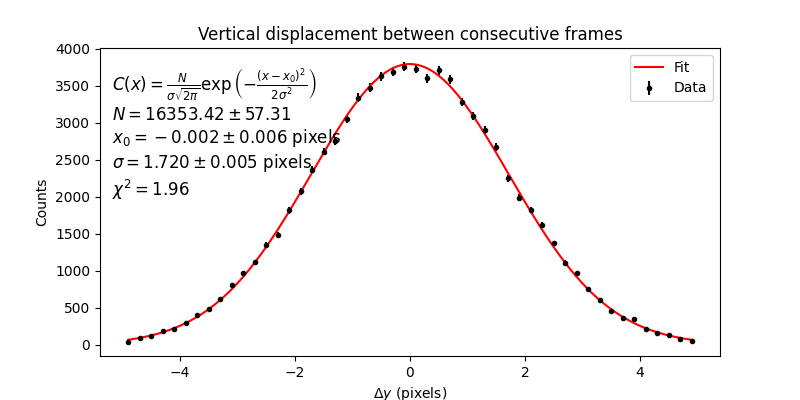

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(cbins, dyhist[0], errdy, fmt='k.', label='Data')

X = np.linspace(min(cbins), max(cbins), 5000)
ax.plot(X, fitfunc(pfy, X), 'r-', label='Fit')

ax.set_title('Vertical displacement between consecutive frames')
ax.set_xlabel('$\Delta y$ (pixels)')
ax.set_ylabel('Counts')
ax.legend()

textfity = '$C(x) = \\frac{N}{\sigma\sqrt{2\pi}}\\exp\\left(-\\frac{(x-x_0)^2}{2\sigma^2}\\right)$ \n'
textfity += '$N = {:.2f} \pm {:.2f}$ \n'.format(pfy[0], pferry[0]) 
textfity += '$x_0 = {:.3f} \pm {:.3f}$ pixels\n'.format(pfy[1], pferry[1]) 
textfity += '$\sigma= {:.3f} \pm {:.3f}$ pixels \n'.format(pfy[2], pferry[2]) 
textfity += '$\chi^2= {:.2f}$ \n'.format(chisqy/dofy) 

#ax.set_xlim(left=-2.3)
ax.text(0.02, .94, textfity, transform=ax.transAxes, fontsize=12,
             verticalalignment='top')

if (save_pic):
    {
    plt.savefig(output_folder + '/histogram_dy.pdf')
    }
plt.show()

Now that we've fit our data, let's put everything together and try to find our diffusion coefficient experimentally.  We'll need to define a number of variables below to make the conversion

In [54]:
# Particle radius
a = 0.96*10**(-6)/2  # m

# Video frame rate and time between frames
framerate = 10 # frames per second
dt = 1/framerate # s

# Absolute temperature and Boltzmann constant
T = 297 # K
k_B = 1.3806*10**(-23) # m^2 kg/(s^2 K)

# Conversion factor between real length and pixel length
conversion = 0.01*10**(-3)/61.0 # m/pixel

# Viscosity of water (at temperature T)
eta = 8.90*10**(-4)  # Pa s = kg/(s m)

In [55]:
#Take the average of your two sigma values, and convert to real length units

#This averages the step sizes together and then adds the spreads for the x and y data in quadrature.
sigma = (np.abs(sigma_x) + np.abs(sigma_y))/2 * conversion # m
dsigma = np.sqrt(dsigma_x**2 + dsigma_y**2)/2 * conversion # m

#Computes the diffusion coefficient
D = ((sigma**2)/2)/dt     # m^2/s
dD = D*(dsigma/sigma) # m^2/s

#Computes the expected diffusion coefficient
D_predicted = k_B*T/(6*np.pi*eta*a)
dD_predicted = k_B*T/(6*np.pi*eta*a) * np.sqrt((1.0/T)**2 + (0.01**2)) # This is assuming uncertainty comes from measuring temperature to 1 degree and measuring radius to 1%

print('D_predicted = {:.4f} +/- {:.4f} x 10^(-13) m^2/s'.format(D_predicted/10**(-13),dD_predicted/10**(-13)))
print('D_exp = ({:.4f} +/- {:.4f}) x 10^(-13) m^2/s'.format(D/10**(-13), dD/10**(-13)))

D_predicted = 5.0920 +/- 0.0537 x 10^(-13) m^2/s
D_exp = (3.9721 +/- 0.0075) x 10^(-13) m^2/s


Our fits were good, so this large discrepancy between measured and predicted diffusion coefficient is an indication that there might be something other than pure brownian motion ocurring in our sample data.

Don't be distraught if your data has similar issues at first!  You may need to take more carefully controlled data (this had a lot of particle pairs) or better filter what you already have.